# Project - Analyzing Reviews in STEAM Community

**Group 5**

**Team members**:
- Chenyang, Jia-Jia, Shuang, Xinbo

**Credit listing:** 
- Chenyang Zheng: Created API accounts; Data collection from APIs, including review data and game stats data; Explore and define fake review patterns; Built fake review detection model.
- Xinbo Lu: Created API accounts; Data collection from APIs, including review data and game stats data; Analyzed the relationship between gaming time and toxicity level of reviews.
- Jia-Jia Yu: Problem & Research questions; Data processing (convert utc time to date time, clean the review); Measure toxicity levels of reviews; Explore and define fake review patterns; Built fake review detection model.
- Shuang Zhao: Problem & Research questions; Data description; Measured toxicity level of reviews; Sentiment analysis on the reviews; Write the processed dataframes to csv files for future use; Analyzed the sentiment change over time.

**Revisiting on Our Research Questions:**

(1) Did user sentiment changed positively, negatively, or stayed relatively similar compared to pre-pandemic, and why?

(2) What is the relationship between toxicity level of reviews and user gaming time?

(3) What are typical linguistic patterns of fake reviews in the Steam Community?


# Data Collection & Processing

- Steam API: get review (40,000 + reviews)

- Perspective API: measure toxicity of reviews (10,000 reviews due to rate limit)

# RQ1: Did user sentiment changed positively, negatively, or stayed relatively similar compared to pre-pandemic?

In [ ]:
# Set up to load files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import requests
import nltk, re, json, io
from collections import Counter
from collections import defaultdict
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import matplotlib
pd.options.mode.chained_assignment = None 

In [ ]:
# Load data
df_dota2 = pd.read_csv('/content/gdrive/MyDrive/IMT547/dota2_10k_toxcity_sentiment_fake.csv')
df_dota2.head(2)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,textblob_subjectivity,extreme_polarity,fake_no_digits,fake_word_counts,fake_ratio_fp_words,fake_ratio_uppercases,fake_punc_count,fake_short_wordcnt,fake_ratio_numsymbol,fake_extreme_polarity
0,13844852,steamid 76561198108867118 num_games_owned 2 nu...,english,THE BEST GAME EVER !,1420449658,1420449658,True,5,0,0.582656,...,0.3500,False,0,5,0.000,0.750,1,2,0.050,False
1,9587132,steamid 76561197998745774 num_games_owned 17 n...,english,Ahhh.... Dota 2. This game is severaly unbalan...,1395437376,1609582255,True,5,2,0.547834,...,0.3375,False,5,126,0.008,0.024,22,42,0.038,False


In [ ]:
df_dota2.shape

(9459, 31)

##### Visualization of Sentiments over Time

In [ ]:
# Check the time span of the reviews
print("First data point: ", df_dota2['time_created'].min(), "Last data point: ", df_dota2['time_created'].max())

First data point:  2011-08-01 14:10:24 Last data point:  2022-05-13 20:04:36


**The reviews range from August 2011 to May 2022,  covering pre-pandemic periods.**

In [ ]:
# Extract month-level date from time_created
df_dota2['yearmonth'] = df_dota2['time_created'].apply(lambda x: x[:7]) 

In [ ]:
df_month = df_dota2.groupby('yearmonth').agg('mean')
df_month = df_month.reset_index()

In [ ]:
# Convert yearmonth column to datetime object
df_month['datetime_yearmonth'] = pd.to_datetime(df_month['yearmonth'])

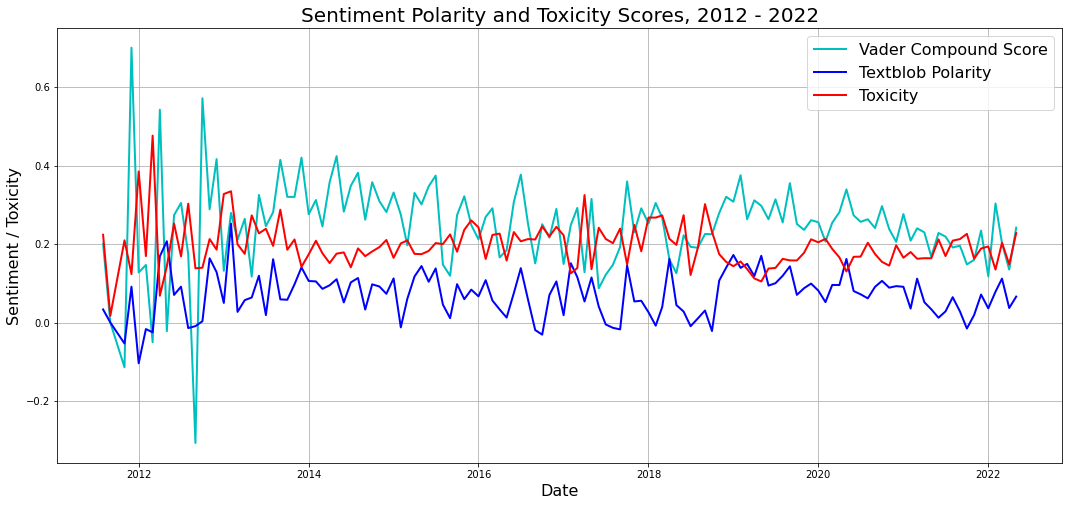

In [ ]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
ax.plot(df_month['datetime_yearmonth'],
       df_month['vader_com'],
       color='c', lw=2, label = 'Vader Compound Score')

ax.plot(df_month['datetime_yearmonth'],
       df_month['textblob_polarity'],
       color='b', lw=2, label = 'Textblob Polarity')

ax.plot(df_month['datetime_yearmonth'],
       df_month['toxicity_perspective'],
       color='r', lw=2, label = 'Toxicity')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Add grid
plt.grid(b=True, which='both', axis='both')
plt.legend(fontsize = 16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Sentiment / Toxicity', fontsize=16)
plt.title('Sentiment Polarity and Toxicity Scores, 2012 - 2022', fontsize = 20)
plt.show()

**Inference**

- The volatile fluctuations in early dates are caused by on-going beta testings of the game. From 2011 to mid 2013, Dota2 was continuously testing its beta versions. And finally, Dota2 was *officially released in July 2013*. Since then, the sentiments become less volatile.
- The sentiment polarity seems to have a overall trend of decreasing from first quarter in 2020 to 2022. We will test this in following steps.


##### Define Time Periods

- **Pre-pandemic:** Before 2020 March
  
  Reasoning: 2020 March is a key date for the majority of countries to shift to more stringent covid-related policies. 

  C.D.C recommended no gatherings of 50 or more people in the U.S.. 
  E.U. restricted travelers from outside the E.U. regions. 
  India also announced the 21-day lockdown policy in March 2020.
    
    
- **Peaks of pandemic:** 2020 March - 2021 June

  Reasoning: In most states in the U.S., mask mandates have eased, restrictions have lifted and people have gone back to business.


##### Key dates related to Covid

- March 15, 2020: The C.D.C. recommended no gatherings of 50 or more people in the U.S.
- March 17, 2020: The E.U. barred most travelers from outside the bloc.
- March 24, 2020: India announced a 21-day lockdown.
- May 31, 2021: Alabama’s public health order would expire on May 31 and that restrictions on senior care facilities, hospitals and nursing homes would be lifted.
- June 26, 2021: In Florida, a state of emergency was allowed to expire on June 26.
- October 1, 2021:  N.Y.C. was the first major U.S. city to reopen all its public schools for in-person learning.

References:

https://www.nytimes.com/article/coronavirus-timeline.html

https://www.nytimes.com/interactive/2020/us/states-reopen-map-coronavirus.html




In [ ]:
# Generated a column to assign values based on time breaks

# Before 2020 March
df_dota2['covid'] = 2

# 2020, March - 2021, June
df_dota2.loc[df_dota2.yearmonth <'2020-03','covid'] = 1 

# 2021, June - 2022 May
df_dota2.loc[df_dota2.yearmonth >'2021-06','covid'] = 3

In [ ]:
# calculate mean by covid group
df_covid = df_dota2[['covid','toxicity_perspective','vader_com']].groupby(['covid']).agg('mean')

In [ ]:
# inspect df_covid
df_covid

,toxicity_perspective,vader_com
covid,,
1,0.185453,0.278276
2,0.168744,0.254618
3,0.187443,0.191532


1 - Pre-pandemic (Before 2020 March)

2 - Peak of pandemic (2020 April - 2021 June)

3 - After the peak of pandemic (2021 July - 2022 May)

**Inference**
- It seems that the sentiment scores measured by VADER decreased during the peak of pandemic.
- The toxicity level of reviews decreased during the peak of pandemic and returned to the level before pandemic since 2021 June. 

##### Run t-tests to Check If Differences are Statistically Significant

######VADER Sentiment Scores

In [ ]:
from scipy import stats

In [ ]:
# Pre-pandemic & Peaks of pandemic
stats.ttest_ind(df_dota2[df_dota2['covid']==1]['vader_com'], df_dota2[df_dota2['covid']==2]['vader_com'])

Ttest_indResult(statistic=1.9946574842103848, pvalue=0.046111572358890046)

**Interpretation**

- The difference of sentiment polarities between pre-pandemic and peak of pandemic is significant on the confidence level of 95%. 
- That is to say, that there is a decrease in sentiment polarity during the peaks of pandemic. 
- People had LESS POSITIVE sentiment during the peak of pandemic.

In [ ]:
# Peaks of pandemic & Post peak pandemic
stats.ttest_ind(df_dota2[df_dota2['covid']==2]['vader_com'], df_dota2[df_dota2['covid']==3]['vader_com'])

Ttest_indResult(statistic=3.3735342963879233, pvalue=0.0007521307701256443)

**Interpretation**

- The difference of sentiment polarities between peak of pandemic and post peak pandemic is significant on the confidence level of 99%.
- That is to say, that there is a decrease in sentiment polarity during and after the peaks of pandemic. 
- People have LESS POSITIVE sentiment after the peak of pandemic.

###### Toxicity Scores

In [ ]:
df_covid.toxicity_perspective

covid
1    0.185453
2    0.168744
3    0.187443
Name: toxicity_perspective, dtype: float64

In [ ]:
# Pre-pandemic & Peaks of pandemic
stats.ttest_ind(df_dota2[df_dota2['covid']==1]['toxicity_perspective'], df_dota2[df_dota2['covid']==2]['toxicity_perspective'])

Ttest_indResult(statistic=2.9046132677953196, pvalue=0.003686381971286278)

In [ ]:
# Peaks of pandemic & Post peak pandemic
stats.ttest_ind(df_dota2[df_dota2['covid']==2]['toxicity_perspective'], df_dota2[df_dota2['covid']==3]['toxicity_perspective'])

Ttest_indResult(statistic=-2.0595554188895595, pvalue=0.0395327583413057)

**Interpretation**

- The toxicity level of reviews significantly decreased during the peak of pandemic.
- After the peak of pandemic, the toxicity level significantly increased and returned to the similar level of pre-pandemic period.



# RQ2: What is the relationship between toxicity level of reviews and user gaming time?




#####**Modeling gaming time and toxicity score**

We would like to see whether game times will affect the attitude of players' comment. From the scapped data, we are able to find several key measurements, such as play time forever and play time at review. In addition, we used the calculated toxicity score from the last assignment as our depedent variable. Our baseline model adopted ElasticNet regression and used the MAE(Mean Absolute Error) and MSE (Mean Sqaure Error) to access the performance, which are 0.173 and 0.230 respectively. The scores indicated the toxicity score could be measured by different gaming time variables.

In [ ]:
## create empty lists to store the game time
playtime_forever = []
playtime_last_two_weeks=[]
play_time_at_review = []

## loop through the nest list in the author column
for i in range(len(df_dota2.author)):
    ## clean the unnecessary punctuation
    df_dota2.author[i] = df_dota2.author[i].replace('\'', '')
    df_dota2.author[i] = df_dota2.author[i].replace('{', '')
    df_dota2.author[i] = df_dota2.author[i].replace('}', '')
    df_dota2.author[i] = df_dota2.author[i].replace(':', '')
    df_dota2.author[i] = df_dota2.author[i].replace(',', '')
    ## first split using the space
    gametime_split = df_dota2.author[i].split(' ')
    ## loop through the splitted sentence, now in list format 
    ## extract the game time numbers
    for j in range(len(gametime_split)):
        if(gametime_split[j] =='playtime_forever'):
            playtime_forever.append(gametime_split[j+1]) ##get next item
        elif(gametime_split[j] == 'playtime_last_two_weeks'):
            playtime_last_two_weeks.append(gametime_split[j+1])
        elif(gametime_split[j] == 'playtime_at_review'):
            play_time_at_review.append(gametime_split[j+1])

In [ ]:
## The orginal data contains empty value for play time at review, so we are going to add zeros.
missing_play_time_at_review = [0,0,0]
play_time_at_review = play_time_at_review + missing_play_time_at_review

In [ ]:
## Create depedent and independent dataset
X = pd.DataFrame(list(zip(playtime_forever, playtime_last_two_weeks, play_time_at_review)), 
                 columns=['playtime_forever', 'playtime_last_two_weeks','playtime_at_review'])
#y = data.toxicity_perspective
y = df_dota2.toxicity_perspective

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
## train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
## create the ElasticNet model and feed in the data
enet_model = ElasticNet(alpha=20.0, l1_ratio=0.5, random_state=1).fit(X_train, y_train)
## get y_prediction
y_pred = enet_model.predict(X_test)

In [ ]:
## calculate mse
np.sqrt(mean_squared_error(y_test,y_pred))

0.23045372685903662

We also want to know how the model will perform by using cross validation

In [ ]:
## same model but for cv
model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=1)

In [ ]:
## creat a Kfold object
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

## get cv score using neg_mean_absolute_error
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

## convert scores as absolutes
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 0.173 (0.003)


# RQ3: What are typical linguistic patterns of fake reviews in the Steam Community?


## Fake Review Modeling

### Part I. Suspicious pattern clustering

Since there's no general predefined criteria for "fake review", we determine to perform **8 tasks that can identify suspicious patterns** of fake reviews:

1. Find the total number of numbers
2. Find the length of review tokens (T)
3. Find the Ratio of total number of first-person words
4. Find the Ratio of total number of uppercase letters
5. Find the total number of punctuation symbols
6. Find the total number of short words
7. Find the ratio of total number of digits and symbols
8. Find extreme sentiment scores

After calculating suspicious pattern scores for each review, we decide to use unsupervised model, "K-means clustering to group similar reviews together. 

In the process, we use elbow method to find the most optimal K, and we go with 20 clusters. ( Will explain why we use cluster=20 in below code block)


The cluster, namely our new variable, is treated as our conclusion on all fake review patterns above and can be used in later supervised-model analysis. 


In [ ]:
# Load our data
fake_df = pd.read_csv('/content/gdrive/MyDrive/IMT547/dota2_10k_toxcity_sentiment_fake.csv')
fake_df = fake_df[['fake_no_digits', 'fake_word_counts', 'fake_ratio_fp_words', 'fake_ratio_uppercases', 'fake_punc_count', 'fake_short_wordcnt', 
                  'fake_ratio_numsymbol', 'fake_extreme_polarity']]
# Convert "True, Flase" to "0, 1" for our model
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
fake_df['fake_extreme_polarity'] = le.fit_transform(fake_df['fake_extreme_polarity'])
# Feature scaling with MinMaxScaler
cols = fake_df.columns
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()
fake_df_sc = ms.fit_transform(fake_df)
fake_df_sc = pd.DataFrame(fake_df_sc, columns=[cols])
fake_df_sc.head(2)

,fake_no_digits,fake_word_counts,fake_ratio_fp_words,fake_ratio_uppercases,fake_punc_count,fake_short_wordcnt,fake_ratio_numsymbol,fake_extreme_polarity
0,0.00000,0.002797,0.000,0.750,0.003086,0.003861,0.059172,0.0
1,0.03876,0.087413,0.016,0.024,0.067901,0.081081,0.044970,0.0


In [ ]:
# Apply k-means clustering with 2 clusters first to get a sense of inertia score performance.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0) 
kmeans.fit(fake_df_sc)
kmeans.inertia_
# Inertia: It is the sum of squared distances of samples to their closest cluster center, therefore the lower the score, the better the model is.
# It means that we need to explore further to find a better k.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


585.9335576743993

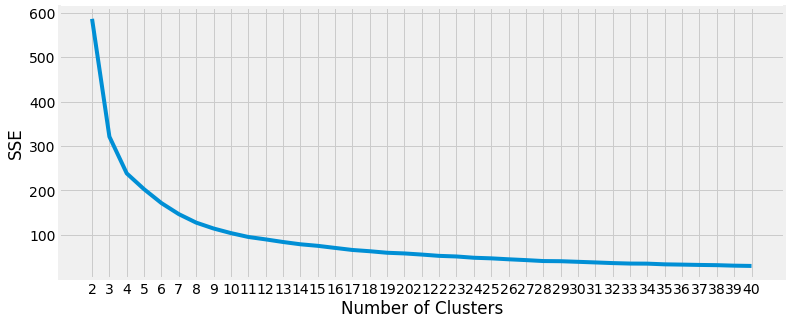

In [ ]:
# Elbow method with inertia: loop through k= 2-40 to identify the most optimal number of clusters. 
from sklearn.cluster import KMeans
scorelist = []
for i in range(2,41):
  kmeans = KMeans(n_clusters=i, random_state=0) 
  kmeans.fit(fake_df_sc)
  scorelist.append(kmeans.inertia_)
print(scorelist)
# Visualization of the elbow method:
plt.figure(figsize=(13,5)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, 41), scorelist)
plt.xticks(range(2, 41))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
# We know that there’s a trade-off because as K increases, inertia decreases, yet considering computational/training cost, 
# normally we would choose the point after which the inertia start decreasing in a linear pattern(9 or 10 in our case here). 
# But the inertia score is still high at around 10, given our dataset is quite small, we decide to try bigger k values 
# to get lower Inertia score. Finally, We decide to go with 20 and the computational time is acceptable.

In [ ]:
# Apply cluster=20
kmeans = KMeans(n_clusters=20, random_state=0) 
result = kmeans.fit(fake_df_sc)
y_pred = result.predict(fake_df_sc)
y_pred.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


(9459,)

In [ ]:
new_cluster_df = all_df.copy()
new_cluster_df['cluster'] = y_pred
new_cluster_df.head(2)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,textblob_subjectivity,fake_no_digits,fake_word_counts,fake_ratio_fp_words,fake_ratio_uppercases,fake_punc_count,fake_short_wordcnt,fake_ratio_numsymbol,fake_extreme_polarity,cluster
0,13844852,"{'steamid': '76561198108867118', 'num_games_ow...",english,THE BEST GAME EVER !,1420449658,1420449658,True,5,0,0.582656,...,0.3500,0,5,0.000,0.750,1,2,0.050,False,7
1,9587132,"{'steamid': '76561197998745774', 'num_games_ow...",english,Ahhh.... Dota 2. This game is severaly unbalan...,1395437376,1609582255,True,5,2,0.547834,...,0.3375,5,126,0.008,0.024,22,42,0.038,False,12


### Part II. Supervised model with manual labeling
1. **How we hand-label fake reviews**

In order to detect fake review with supervised model, we hand-label 700 reviews using below criteria:
- Ratio of digit in each review >=80%
- The length of review tokens <=4
- Ratio of total number of first-person words >=1.8%
- Ratio of total number of uppercase letters >=8.8%
- Ratio of number of punctuation symbols >=17.89%
- Ratio number of short words (less than 3 letters) >37.31%
- Ratio of total number of digits and symbols >4.31%

After hand-labeling, 38.5% of all reviews are considered "fake" in 700 reviews.

2. **Model selection:** 
For fake review prediction, we decide to apply KNN model since our labeled dataset is small and with less features and noise. KNN model performs better with this condition. 

In [ ]:
 # Load our hand-label data
 df_ex = pd.read_csv('/content/gdrive/MyDrive/IMT547/LABELED_dota2_10k_toxcity_sentiment_fake_cluster - LABELED_dota2_10k_toxcity_sentiment_fake_cluster - LABELED_dota2_10k_toxcity_sentiment_fake_cluster - LABELED_dota2_10k_toxcity_sentiment_fake_cluster.csv')
 del df_ex['note']
df_ex.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,fake_ratio_fp_words,fake_ratio_uppercases,fake_punc_count,fake_punc_count %,fake_short_wordcnt,fake_short_wordcnt %,fake_ratio_numsymbol,fake_extreme_polarity,cluster,is_fake
0,13844852.0,"{'steamid': '76561198108867118', 'num_games_ow...",english,THE BEST GAME EVER !,1.420450e+09,1.420450e+09,True,5.0,0.0,0.582656,...,0.000,0.750,1,0.2000,2.0,0.4000,0.050,False,7.0,1.0
1,9587132.0,"{'steamid': '76561197998745774', 'num_games_ow...",english,Ahhh.... Dota 2. This game is severaly unbalan...,1.395437e+09,1.609582e+09,True,5.0,2.0,0.547834,...,0.008,0.024,22,0.1746,42.0,0.3333,0.038,False,12.0,0.0
2,8744049.0,"{'steamid': '76561198058224607', 'num_games_ow...",english,"hard to learn, inpossible to master, yet its s...",1.389990e+09,1.389990e+09,True,3.0,0.0,0.550048,...,0.000,0.009,3,0.1500,10.0,0.5000,0.028,False,2.0,0.0
3,55163678.0,"{'steamid': '76561198004052055', 'num_games_ow...",english,Boring and full of stupid people,1.568775e+09,1.568775e+09,False,6.0,0.0,0.544656,...,0.000,0.031,0,0.0000,2.0,0.3333,0.000,True,18.0,0.0
4,90931618.0,"{'steamid': '76561198074657533', 'num_games_ow...",english,"Ive played over 1300 hours at this game, and i...",1.619406e+09,1.619406e+09,True,1.0,0.0,0.523810,...,0.071,0.015,2,0.1429,6.0,0.4286,0.091,True,18.0,0.0


In [ ]:
# 0= counts of review we consider normal, 1= counts of review we consider fake
df_ex['is_fake'].value_counts()

0.0    430
1.0    270
Name: is_fake, dtype: int64

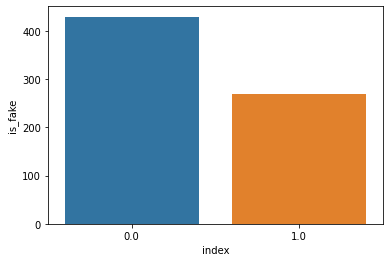

In [ ]:
# Visually shows our distribution of fake/non-fake reviews.
plott = (df_ex['is_fake'].value_counts()).to_frame().reset_index()
sns.barplot(x='index',y='is_fake',data=plott)

In [ ]:
df_ex.columns

Index(['recommendationid', 'author', 'language', 'review', 'timestamp_created',
       'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny',
       'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access', 'time_created',
       'clean_review', 'toxicity_perspective', 'vader', 'vader_compound',
       'vader_com', 'textblob_polarity', 'textblob_subjectivity',
       'fake_no_digits', 'fake_no_digits %', 'fake_word_counts',
       'fake_ratio_fp_words', 'fake_ratio_uppercases', 'fake_punc_count',
       'fake_punc_count %', 'fake_short_wordcnt', 'fake_short_wordcnt %',
       'fake_ratio_numsymbol', 'fake_extreme_polarity', 'cluster', 'is_fake'],
      dtype='object')

In [ ]:
# Preparation for KNN 1-- Relevant Feature selection
df_knn = df_ex.drop(columns=['recommendationid', 'author', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'time_created',
                             'clean_review', 'vader','vader_compound','fake_no_digits %','fake_punc_count %','fake_short_wordcnt %'])
df_knn.head(２)

,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,toxicity_perspective,vader_com,...,fake_no_digits,fake_word_counts,fake_ratio_fp_words,fake_ratio_uppercases,fake_punc_count,fake_short_wordcnt,fake_ratio_numsymbol,fake_extreme_polarity,cluster,is_fake
0,True,5.0,0.0,0.582656,0.0,False,False,False,0.028439,0.6369,...,0.0,5.0,0.000,0.750,1,2.0,0.050,False,7.0,1.0
1,True,5.0,2.0,0.547834,0.0,False,False,False,0.655660,-0.8005,...,5.0,126.0,0.008,0.024,22,42.0,0.038,False,12.0,0.0


In [ ]:
# Preparation for KNN 2-- turn (True,False) to (0,1) 

le = LabelEncoder()
df_knn['voted_up'] = le.fit_transform(df_knn['voted_up'])
df_knn['received_for_free'] = le.fit_transform(df_knn['received_for_free'])
df_knn['written_during_early_access'] = le.fit_transform(df_knn['written_during_early_access'])
df_knn['fake_extreme_polarity'] = le.fit_transform(df_knn['fake_extreme_polarity'])
df_knn['steam_purchase'] = le.fit_transform(df_knn['steam_purchase'])
df_knn.head(2)

,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,toxicity_perspective,vader_com,...,fake_no_digits,fake_word_counts,fake_ratio_fp_words,fake_ratio_uppercases,fake_punc_count,fake_short_wordcnt,fake_ratio_numsymbol,fake_extreme_polarity,cluster,is_fake
0,1,5.0,0.0,0.582656,0.0,0,0,0,0.028439,0.6369,...,0.0,5.0,0.000,0.750,1,2.0,0.050,0,7.0,1.0
1,1,5.0,2.0,0.547834,0.0,0,0,0,0.655660,-0.8005,...,5.0,126.0,0.008,0.024,22,42.0,0.038,0,12.0,0.0


In [ ]:
# Preparation for KNN 3-- Drop NA values and confirm that our data is numeric 
df_knn=df_knn.dropna()
df_knn = df_knn.apply(pd.to_numeric)
type(df_knn['fake_ratio_numsymbol'][0])

numpy.float64

In [ ]:
# Assign our independent variables and dependent variable
X = df_knn.drop('is_fake', axis=1)
y = df_knn['is_fake']
# Preparation for KNN 4-- Feature scaling with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)

df_feat = pd.DataFrame(scaled_features,columns=X.columns) # drop 'TARGET CLASS'
df_feat.head()

,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,toxicity_perspective,vader_com,...,textblob_subjectivity,fake_no_digits,fake_word_counts,fake_ratio_fp_words,fake_ratio_uppercases,fake_punc_count,fake_short_wordcnt,fake_ratio_numsymbol,fake_extreme_polarity,cluster
0,0.445679,-0.026690,-0.109048,0.961950,-0.23843,-0.065606,-0.229416,0.0,-0.695443,0.812952,...,-0.143853,-0.371785,-0.280755,-0.326018,3.113138,-0.278436,-0.262820,0.050997,-0.283279,-0.187420
1,0.445679,-0.026690,0.008569,0.122492,-0.23843,-0.065606,-0.229416,0.0,2.048638,-2.243409,...,-0.189674,1.573278,1.565083,-0.184315,-0.360509,1.618232,1.275102,-0.114975,-0.283279,0.647149
2,0.445679,-0.094627,-0.109048,0.175870,-0.23843,-0.065606,-0.229416,0.0,-0.120887,0.578633,...,-0.067486,-0.371785,-0.051932,-0.326018,-0.432278,-0.097801,0.044765,-0.253286,-0.283279,-1.021989
3,-2.243765,0.007279,-0.109048,0.045890,-0.23843,-0.065606,-0.229416,0.0,3.266975,-2.010152,...,1.688970,-0.371785,-0.265500,-0.326018,-0.327016,-0.368754,-0.262820,-0.640555,3.530090,1.648631
4,0.445679,-0.162565,-0.109048,-0.456667,-0.23843,-0.065606,-0.229416,0.0,0.377121,-0.866834,...,1.139123,1.184266,-0.143461,0.931596,-0.403570,-0.188118,-0.109028,0.618070,3.530090,1.648631


In [ ]:
# First attemp-- Apply KNN model with default setting(n_neighbors = 5)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(df_feat,y, test_size=0.30, random_state= 101)
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(classification_report(y_test,pred))
# Model accuracy= 71% 

              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74       124
         1.0       0.63      0.70      0.66        86

    accuracy                           0.71       210
   macro avg       0.70      0.71      0.70       210
weighted avg       0.72      0.71      0.71       210



Text(0, 0.5, 'Error Rate')

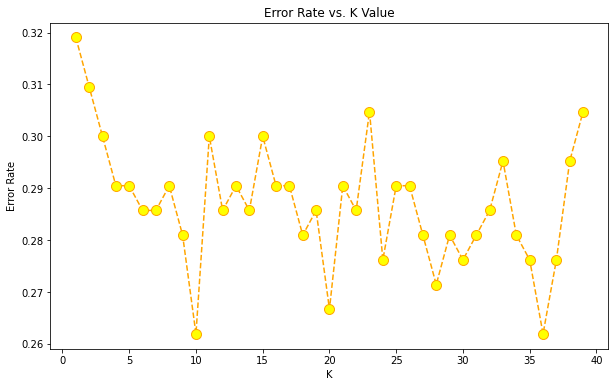

In [ ]:
# Tune K values by checking error rate in the case from k=1 to k=40.
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

# plot the error rate
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='orange', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
# There's a significant drop of error rate when k=10, so we decide to go with 10 neighbors.
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(classification_report(y_test,pred))
# Our final model accuracy is arounf 74% 

              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78       124
         1.0       0.70      0.64      0.67        86

    accuracy                           0.74       210
   macro avg       0.73      0.72      0.73       210
weighted avg       0.74      0.74      0.74       210



In [ ]:
# Make prediction with updated model of the rest of (un-labeled)dataset 
df_2 = pd.read_csv('/content/gdrive/MyDrive/IMT547/LABELED_dota2_10k_toxcity_sentiment_fake_cluster - LABELED_dota2_10k_toxcity_sentiment_fake_cluster - LABELED_dota2_10k_toxcity_sentiment_fake_cluster - LABELED_dota2_10k_toxcity_sentiment_fake_cluster.csv')
del df_2['note']
# The same process: feature selection, apply label encoder, feature scaling, assigning X&Y
df_knn_unlabeled = df_2.drop(columns=['recommendationid', 'author', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'time_created',
                             'clean_review', 'vader','vader_compound','fake_no_digits %','fake_punc_count %','fake_short_wordcnt %'])
le = LabelEncoder()
df_knn_unlabeled['voted_up'] = le.fit_transform(df_knn_unlabeled['voted_up'])
df_knn_unlabeled['received_for_free'] = le.fit_transform(df_knn_unlabeled['received_for_free'])
df_knn_unlabeled['written_during_early_access'] = le.fit_transform(df_knn_unlabeled['written_during_early_access'])
df_knn_unlabeled['fake_extreme_polarity'] = le.fit_transform(df_knn_unlabeled['fake_extreme_polarity'])
df_knn_unlabeled['steam_purchase'] = le.fit_transform(df_knn_unlabeled['steam_purchase'])
df_knn_unlabeled = df_knn_unlabeled[df_knn_unlabeled['is_fake'].isnull()]
df_knn_unlabeled.head(2)
df_knn_unlabeled=df_knn_unlabeled.dropna(subset=['votes_up','votes_funny','weighted_vote_score','comment_count','toxicity_perspective',
                      'vader_com','textblob_polarity','textblob_subjectivity' ,'fake_no_digits','fake_word_counts',
                      'fake_ratio_fp_words','fake_ratio_uppercases','fake_short_wordcnt','fake_ratio_numsymbol','fake_extreme_polarity'
                      ,'cluster'])
X = df_knn_unlabeled.drop('is_fake', axis=1)

scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)

df_feat_unlabeled = pd.DataFrame(scaled_features,columns=X.columns) # drop 'TARGET CLASS'
pred_unlabeled = knn.predict(df_feat_unlabeled)
df_knn_unlabeled['is_fake'] = pred_unlabeled  # Make prediction

# First 700 low of data remains our hand labels.  
first_half = df_2.dropna()
# For the rest of unlabeled data, we attach the prediction result. 
second_half = df_2.iloc[700:, :]
second_half = second_half.dropna(subset=['votes_up','votes_funny','weighted_vote_score','comment_count','toxicity_perspective',
                      'vader_com','textblob_polarity','textblob_subjectivity' ,'fake_no_digits','fake_word_counts',
                      'fake_ratio_fp_words','fake_ratio_uppercases','fake_short_wordcnt','fake_ratio_numsymbol','fake_extreme_polarity'
                      ,'cluster'])
second_half['is_fake'] = pred_unlabeled

In [ ]:
# This is the final dataframe with fake-review detection result by combining hand-labing dataframe and model-predicted dataframe.
final_pred = pd.concat([first_half, second_half])
final_pred.tail(2)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,fake_ratio_fp_words,fake_ratio_uppercases,fake_punc_count,fake_punc_count %,fake_short_wordcnt,fake_short_wordcnt %,fake_ratio_numsymbol,fake_extreme_polarity,cluster,is_fake
9457,104740070.0,"{'steamid': '76561198081657223', 'num_games_ow...",english,you wasting your time playing Dota 2,1.638212e+09,1.638212e+09,False,2.0,0.0,0.532943,...,0.0,0.028,0,0.0,2.0,0.2857,0.028,False,2.0,0.0
9458,48620780.0,"{'steamid': '76561198425458569', 'num_games_ow...",english,amazing game,1.548736e+09,1.548736e+09,True,1.0,0.0,0.523810,...,0.0,0.000,0,0.0,0.0,0.0000,0.000,False,2.0,1.0


### Part III. Linguistic patterns based on model prediction


In [ ]:
fake_pred = pd.read_csv('/content/gdrive/MyDrive/IMT547/final_prediction.csv')
df_fakegroup = fake_pred.groupby('is_fake').agg('mean')

**Length & Ratio of Upper-case Letters**

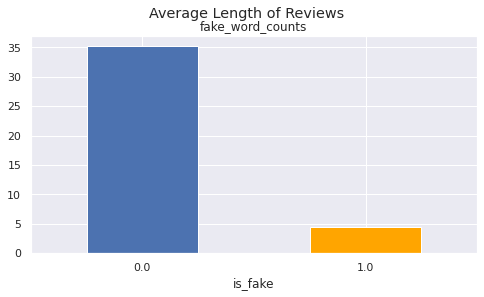

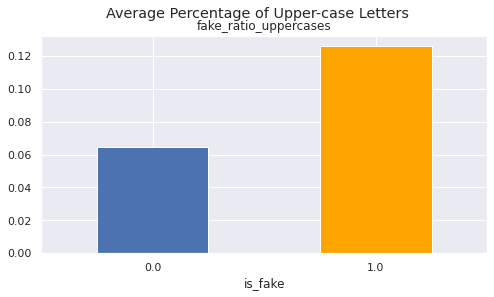

In [ ]:
# Length 
ax = df_fakegroup.plot.bar(y='fake_word_counts', subplots=True,rot=0,figsize=(8, 4),color=['b', 'orange'],
                           title = 'Average Length of Reviews',legend = None)
# Ratio of uppercase letters
ax = df_fakegroup.plot.bar(y='fake_ratio_uppercases',subplots=True, rot=0,figsize=(8, 4),color=['b', 'orange'],
                           title = 'Average Percentage of Upper-case Letters',legend = None)

**Inference**

- Fake reviews have shorter length.
- The ratio of upper-case letters of fake reviews is higher. 

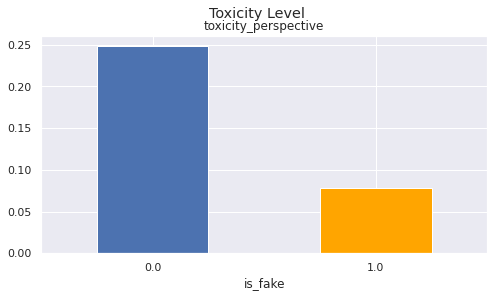

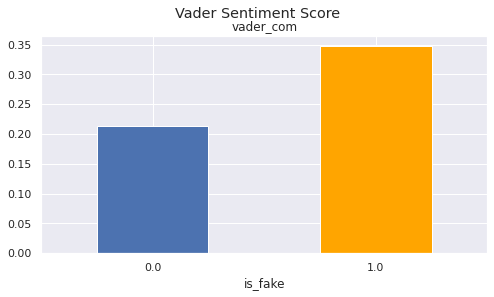

In [ ]:
# Toxicity
ax = df_fakegroup.plot.bar(y='toxicity_perspective',subplots=True, rot=0,figsize=(8, 4),color=['b', 'orange'],
                           title = 'Toxicity Level',legend = None)
# Sentiment polarity
ax = df_fakegroup.plot.bar(y='vader_com',subplots=True, rot=0,figsize=(8, 4),color=['b', 'orange'],
                           title = 'Vader Sentiment Score',legend = None)

**Inference**

- Non-fake reviews are more toxic since real users may be more "hate" or aggressive opinions of the game.
- For similar reasons, fake reviews have more positive sentiemnts.

### Ethical Consideratioin 

- Our first ethical consideration is that we only retrieved game reviews in English in order to visually justify our findings and label the reviews for classification and predictions. However, Dota2 is a popular game globally. Our data collection, in this case, may be less representative and can lead to biases in the sentiment analysis, predictive modeling, and spam classification sections. 
- Secondly, the user name and the review is available without encryption, so if the user accidentally leaked his user game, his comment and attitudes toward other gamers may be revealed through our data. 

### Limitation
- Our first limitation is we did not use all the data we scrapped due to constraints on computational resources. 
- The second limitation is we only gathered English reviews because English is best supported by other NLP packages.

### Future Work
- If we had more time, we would collect reviews from users that are not just limited to English-speaking users. By enlarging our text corpus and text diversity, we can obtain hate speech with more topics around. The comments will not be only targeting one group.
- If we had more time, we would compare more games in different categories.


# Reference:
- Davis, N. (n.d.). Gathering data from the Steam Store API using Python. Gathering Data from the Steam Store API using Python | Nik Davis. Retrieved April 28, 2022, from https://nik-davis.github.io/posts/2019/steam-data-collection/ 
- Fox, J., Gilbert, M., & Tang, W. Y. (2018). Player experiences in a massively multiplayer online game: A diary study of performance, motivation, and social interaction. New Media & Society, 20(11), 4056-4073.
- Gandolfi, E., & Ferdig, R. E. (2021). Sharing dark sides on game service platforms: Disruptive behaviors and toxicity in DOTA2 through a platform lens. Convergence, 13548565211028809.
- Kang, H. N., Yong, H. R., & Hwang, H. S. (2017). A study of analyzing on online game reviews using a data mining approach: Steam community data. International Journal of Innovation, Management and Technology, 8(2), 90.
- Lin, D., Bezemer, C. P., Zou, Y., & Hassan, A. E. (2019). An empirical study of game reviews on the Steam platform. Empirical Software Engineering, 24(1), 170-207.
- Paul, C. A. (2018). The toxic meritocracy of video games: Why gaming culture is the worst. U of Minnesota Press.
- P. Bian, L. Liu, & P. Sweetser. (2021) Detecting Spam Game Reviews on Steam with a Semi-Supervised Approach. Retrieved May 10, 2022, from  
https://openresearch-repository.anu.edu.au/bitstream/1885/230776/1/FDG2021-Reviews.pdf

